# Dog Breed Identification

### Determine the breed of a dog in an image

You are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal of the competition is to create a classifier capable of determining a dog's breed from a photo.


You can get the data here : https://www.kaggle.com/c/dog-breed-identification/data

## This is a rough notebook, out of curiosity worked on a data from Kaggle in the fire run while learning for hours. Will be cleaned up soon. 




In [1]:
from fastai.vision.all import *
import pandas as pd 

# For image 
from fastai.vision import *


In [2]:
# Reading in the label df 

df = pd.read_csv('labels.csv')
df

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [21]:
# Train and test data

test_path = Path('test/')
train_path = Path('train/')

In [4]:
fns_train = get_image_files(train_path)
fns_train

(#10222) [Path('train/f37af9dee180ed1195985decf4ef7111.jpg'),Path('train/547e9cca520970b35c1d9acb0a0fb902.jpg'),Path('train/4b66e3a702acaf31f438fbc12a529892.jpg'),Path('train/4256b386d18a2c34d9d2b982f3a692bd.jpg'),Path('train/0159b6457aac89f43d1c1931cdf7500b.jpg'),Path('train/9708b549ad1a33a5635220927e200fe5.jpg'),Path('train/9236bd07cce91361f798145b5edb8a78.jpg'),Path('train/549bd24432ca6245f78e5ce709b8a3f2.jpg'),Path('train/1929eb9a7cf1fe75c0731a27545d8893.jpg'),Path('train/77f5d224817632147c90ec5bf47a1a27.jpg')...]

In [5]:
# Opening one image 

from PIL import Image 

im = Image.open(r'train/4b66e3a702acaf31f438fbc12a529892.jpg')  

im.shape

(500, 250)

In [8]:
# Augmenting our data 

batch_tfms = aug_transforms(pad_mode = 'zeros' , min_scale = 0.5 , size=224 , batch = True)

In [9]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=ColReader(0, pref=f'train/' , suff='.jpg'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1),
                   item_tfms = Resize(460), 
                    batch_tfms = batch_tfms)

In [10]:
len(fns_train)

10222

In [11]:
pets.dataloaders??

In [12]:
dls = pets.dataloaders(df , batch_size = 64)

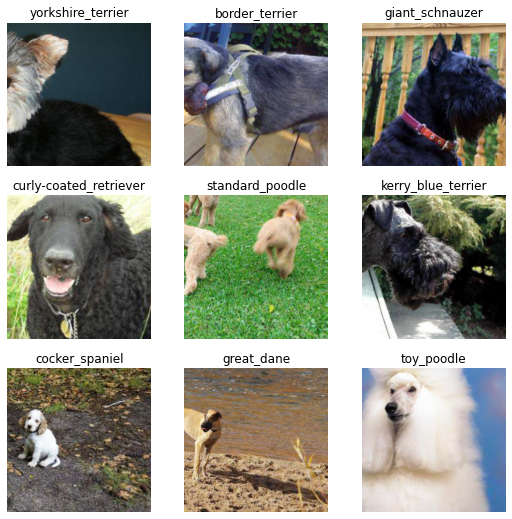

In [13]:
dls.show_batch()

In [ ]:
# Checking how its batched 

list(dls)

In [14]:
len(dls.vocab) , dls.vocab

(120,
 ['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier'

## A Baseline for now

In [19]:
# Training a model asap  -- BASELINE 

learn = cnn_learner(dls , resnet34 , metrics = [error_rate] , pretrained = True)

In [20]:
# Finding the learning rate 

learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,2.694242,0.865333,0.253914,01:24


epoch,train_loss,valid_loss,error_rate,time
0,1.251639,0.805132,0.246575,01:51
1,0.975631,0.694411,0.215753,01:50
2,0.699967,0.631247,0.194716,01:50


Hmm.. Not bad for a baseline one, but gotta tweak a bit and experiment whatever I learnt so far to see if I can make this any better. 

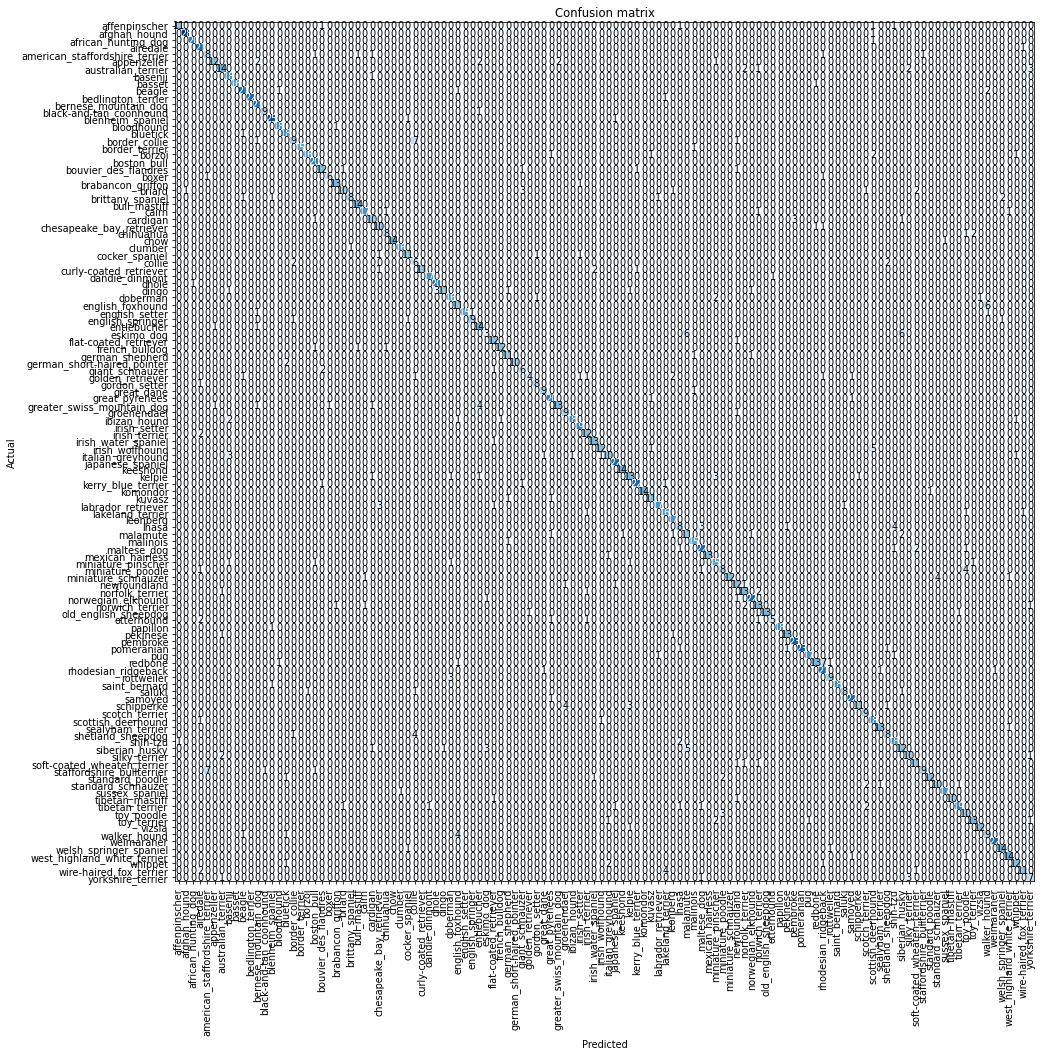

In [22]:
# Using confusion matrix --> to see where our model is doing well and where its not. 

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize = (17 , 15) , dpi = 70)

Shit messed up stuffs. Gotta take care of this.

In [25]:
# Top losses 

interp.most_confused()

[('border_collie', 'collie', 7),
 ('redbone', 'rhodesian_ridgeback', 7),
 ('staffordshire_bullterrier', 'american_staffordshire_terrier', 7),
 ('english_foxhound', 'walker_hound', 6),
 ('eskimo_dog', 'malamute', 6),
 ('eskimo_dog', 'siberian_husky', 6),
 ('irish_wolfhound', 'scottish_deerhound', 5),
 ('siberian_husky', 'malamute', 5),
 ('greater_swiss_mountain_dog', 'entlebucher', 4),
 ('lhasa', 'shih-tzu', 4),
 ('miniature_poodle', 'toy_poodle', 4),
 ('miniature_schnauzer', 'standard_schnauzer', 4),
 ('schipperke', 'groenendael', 4),
 ('shetland_sheepdog', 'collie', 4),
 ('walker_hound', 'english_foxhound', 4),
 ('wire-haired_fox_terrier', 'lakeland_terrier', 4),
 ('australian_terrier', 'yorkshire_terrier', 3),
 ('briard', 'giant_schnauzer', 3),
 ('cardigan', 'pembroke', 3),
 ('dingo', 'dhole', 3),
 ('italian_greyhound', 'basenji', 3),
 ('kelpie', 'miniature_pinscher', 3),
 ('labrador_retriever', 'chesapeake_bay_retriever', 3),
 ('lhasa', 'maltese_dog', 3),
 ('rottweiler', 'doberman',

Fewer confusions happened, didnt expect this.

## TODO

- Play with Augmentations and Transforms 
- Try to subset the data and work on that rather the whole dataset (Challenge) 
- Check out multi class log loss the evalation metrics for the problem. 
- Use Freeze and Unfreeze rather Fine tuning 
- Play with batch size and try to find the maximum (where the error occured) and why it did. 
- If possible try with other models. 
- Refer WWf and try to re-implement. 